In [1]:
# Installation des packages
#!pip install pandas numpy vectorbt matplotlib nbformat python-binance
# CONDA env file : backtest_nb.yml
# conda env create -f backtest_nb.yml

In [2]:
# Importation des packages
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt

---
#### Chargement des données

In [3]:
# Télécharger les données (Utilise Python Binance)
symbol = ['NEARUSDT']

# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2024-01-01 00:00:00',
    end='2025-01-01 00:00:00',
    interval="1h"
)

#Option avec Yfinance pour stocks, forex etc...
#data = vbt.YFData.download

/var/folders/jf/b0f7qprs3qv5hn8d5f4ffv_80000gn/T/ipykernel_4974/3963184750.py:5: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  data = vbt.BinanceData.download(


0it [00:00, ?it/s]

In [4]:
# Agencement des données + index
df_raw = data.get(['Close','Open','High','Low','Volume','Close time']).copy()
df_raw.index = df_raw['Close time']
df_raw.drop('Close time', axis=1, inplace=True)
df_raw.head()

,Close,Open,High,Low,Volume
Close time,,,,,
2023-12-31 20:59:59.999000+00:00,3.743,3.867,3.882,3.738,1244535.8
2023-12-31 21:59:59.999000+00:00,3.722,3.744,3.825,3.722,837927.0
2023-12-31 22:59:59.999000+00:00,3.612,3.723,3.726,3.521,1068400.3
2023-12-31 23:59:59.999000+00:00,3.650,3.612,3.681,3.607,834343.2
2024-01-01 00:59:59.999000+00:00,3.770,3.651,3.787,3.648,929586.2


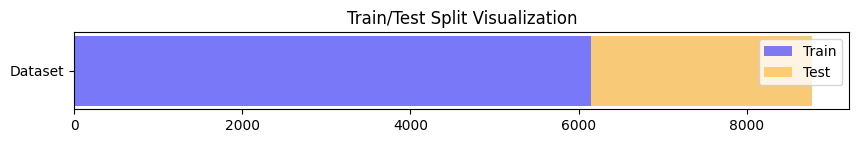

In [5]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [6]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()

---
#### La stratégie

- Type : Mean Reversion
    - Indicateur : BBLOG
    - Entrée  : Cloture au dessous de la bande basse des bandes de bollinger
    - Sortie  :
        - Cloture au dessus de la bande haute des bandes de bollinger  
        Ou  
        - Stop Loss : 5%

In [7]:
def generate_bblog_signals(df, column='Close', window=50, std_dev=1.6):
    # Calcul de la moyenne mobile et écart type
    middle_band = df[column].rolling(window=window).mean()
    roll_std = df[column].rolling(window=window).std()
    
    # Calcul des bandes sup/inf
    df['upper_band'] = middle_band + (std_dev * roll_std)
    df['lower_band'] = middle_band - (std_dev * roll_std)
    
    # Génération des signaux
    df['bb_signal'] = np.where(df[column] < df['lower_band'], 1, 0)
    df['bb_signal'] = np.where(df[column] > df['upper_band'], -1, df['bb_signal'])
     
    return df.dropna()

In [8]:
# Génération des signaux
df = generate_bblog_signals(df, column='Close', window=25, std_dev=1.9)
df.head()

,Close,Open,High,Low,Volume,upper_band,lower_band,bb_signal
Close time,,,,,,,,
2024-01-01 20:59:59.999000+00:00,3.806,3.809,3.834,3.777,947794.5,3.806474,3.530646,0
2024-01-01 21:59:59.999000+00:00,3.797,3.807,3.809,3.752,794520.4,3.814423,3.527017,0
2024-01-01 22:59:59.999000+00:00,3.774,3.797,3.808,3.763,569340.3,3.820594,3.525006,0
2024-01-01 23:59:59.999000+00:00,3.794,3.774,3.817,3.757,822564.1,3.832715,3.527445,0
2024-01-02 00:59:59.999000+00:00,3.855,3.793,3.873,3.737,1763459.1,3.854144,3.522416,-1


In [9]:
def plot_strategy(df, start_date='2023-06-1', end_date='2023-08-05'):
    # Sélection d'une plage de dates spécifique
    data_to_plot = df[start_date:end_date]

    # Création d'une figure avec un seul graphique
    fig, ax = plt.subplots(figsize=(15, 7))

    # Tracer le prix et les bandes
    ax.plot(data_to_plot.index, data_to_plot['Close'], label='Prix', color='blue', alpha=0.7)
    ax.plot(data_to_plot.index, data_to_plot['upper_band'], label='Bande Supérieure', color='gray', linestyle='--', alpha=0.5)
    ax.plot(data_to_plot.index, data_to_plot['lower_band'], label='Bande Inférieure', color='gray', linestyle='--', alpha=0.5)

    # Tracer les signaux d'entrée (triangles verts vers le haut)
    entries = data_to_plot[data_to_plot['bb_signal'] == 1].index
    ax.scatter(entries, data_to_plot.loc[entries, 'Close'],
              color='green', marker='^', s=100, label='Signal d\'Entrée')

    # Tracer les signaux de sortie (triangles rouges vers le bas)
    exits = data_to_plot[data_to_plot['bb_signal'] == -1].index
    ax.scatter(exits, data_to_plot.loc[exits, 'Close'],
              color='red', marker='v', s=100, label='Signal de Sortie')

    # Personnaliser le graphique
    ax.set_title('Stratégie de Trading - Prix et Signaux')
    ax.set_ylabel('Prix')
    ax.set_xlabel('Date')

    # Ajouter la légende
    ax.legend(loc='upper left')

    # Ajouter une grille
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

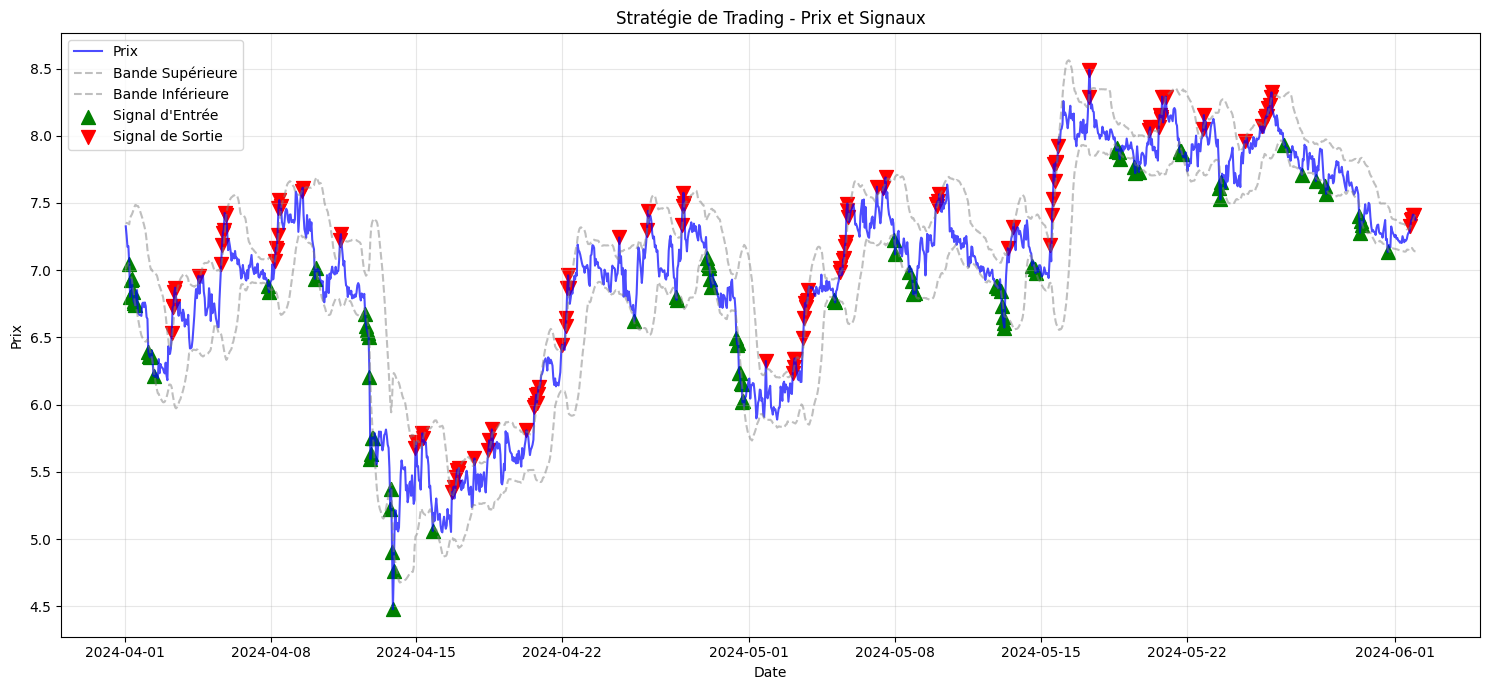

In [10]:
# Visualisation des signaux
plot_strategy(df, start_date='2024-04-1', end_date='2024-06-01')

---
#### Backtest

In [11]:
# Lancement du backtest avec VBT
# Fonction From Signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['bb_signal']==1,
    exits=df['bb_signal']==-1,
    sl_stop=0.05,
    #tp_stop=0.05,
    init_cash=10000,
    fees=0.001, #Taker Binance = 0.1%
    slippage=0.001, #aprox
    freq='1h'
)

# Affichage des statistiques
print(portfolio.stats())

# Tracer la valeur du portefeuille
portfolio.plot(width=1000, height=1000).show()

# Afficher les Trades
fig = portfolio.trades.plot()
fig.update_layout(width=1200, height=600)
fig.show()

Start                         2024-01-01 20:59:59.999000+00:00
End                           2024-09-12 23:59:59.999000+00:00
Period                                       255 days 04:00:00
Start Value                                            10000.0
End Value                                         12297.177485
Total Return [%]                                     22.971775
Benchmark Return [%]                                 11.613242
Max Gross Exposure [%]                                   100.0
Total Fees Paid                                    3230.352992
Max Drawdown [%]                                     55.699684
Max Drawdown Duration                        109 days 07:00:00
Total Trades                                               104
Total Closed Trades                                        104
Total Open Trades                                            0
Open Trade PnL                                             0.0
Win Rate [%]                                         54

--- 

- VBT = Rapide / Efficace / Facile à utiliser
- De très nombreuses possibilités en gratuit
- Pas rentable de créer son propre backtest engine pour un independant
- Une simple stratégie n'est pas rentable (il manque des informations, régime, volat, tendance...)

>https://vectorbt.dev